In [ ]:
# Here are the main steps in the process:
# Step 1. Data Ingestion
# Step 2. Impute Missing Data
# Step 3. Data Cleaning and Transformations
# Step 4. Feature selection: Selecting important features
# Step 6. Feature Engineering
# Step 7. MODELING : Model 1 (Predict binary 0/1 Outcome indicating whether the member responded with donation)
# Step 7. MODELING : Model 2 (Predict amount that a member will donate)
# Step 8. Full model (Model 1 + Model 2) fit and evaluation
# Step 9. Load validation set and make predicitons

In [48]:
# load some packages
import pandas as pd, numpy as np
from collections import Counter

import matplotlib, matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import Ridge, Lasso, ElasticNet 

### STEP 1. Data Ingestion

In [279]:
# STEP 1. DATA INGESTION
# read first few rows and try to understand the columns [data-type, levels]
data_small = pd.read_csv("cup98LRN.txt", error_bad_lines = False, nrows = 1000) # get rid of bad lines
data_small
print(data_small.head())
dtypes = []
for i in range(len(data_small.columns)):
    #print('Column Index : ' + str(i))
    column = data_small.columns[i]
    levels = np.unique(data_small[column])
    #print("Column Type : " + str(data_small[column].dtype))
    dtypes.append(data_small[column].dtype)
    #print('Levels for Column - ' + column + ': ' + str(len(levels)))
    #print(levels)

   ODATEDW OSOURCE  TCODE STATE    ZIP MAILCODE PVASTATE   DOB  NOEXCH  \
0     8901     GRI      0    IL  61081                    3712       0   
1     9401     BOA      1    CA  91326                    5202       0   
2     9001     AMH      1    NC  27017                       0       0   
3     8701     BRY      0    CA  95953                    2801       0   
4     8601              0    FL  33176                    2001       0   

  RECINHSE   ...    TARGET_D HPHONE_D RFA_2R RFA_2F RFA_2A MDMAUD_R  MDMAUD_F  \
0            ...           0        0      L      4      E        X         X   
1            ...           0        0      L      2      G        X         X   
2            ...           0        1      L      4      E        X         X   
3            ...           0        1      L      4      E        X         X   
4        X   ...           0        1      L      2      F        X         X   

  MDMAUD_A CLUSTER2 GEOCODE2  
0        X       39        C  
1     

b'Skipping line 579: expected 481 fields, saw 961\n'


In [50]:
# What are all possible data-types read 
print(np.unique(dtypes))
# Obtain Actual Data-types from file and build a feature to dtype map
f = open('feature_types.txt', 'r')
featureType = {}
for line in f:
    if line[0] == " ":
        feature = (line.split(" ")[2])
        type_ = ([x for x in line.split(" ") if x == "Num" or x == "Char" or x == "Char."])
        if len(feature) > 0 and len(type_) > 0:
            featureType[feature] = type_
featureTypeToDtype = {}
featureTypeToDtype['Char'] = 'O'
featureTypeToDtype['Char.'] = 'O'
featureTypeToDtype['Num'] = np.float64
for feature in featureType.keys() : featureType[feature] = featureTypeToDtype[featureType[feature][0]]
featureType['TCODE'] = 'O' # manually assign known items

[dtype('int64') dtype('float64') dtype('O')]


In [51]:
# READ FULL DATA-SET
data = pd.read_csv("cup98LRN.txt", sep = ",", error_bad_lines = False, dtype = featureType, warn_bad_lines  = False) 

### STEP 2. Impute missing data

In [52]:
# IMPUTE NaN's in data via 
# 1) for continuous values(floats) e.g. ethnic percentages in area, column-median() i.e. middle-value  
# 2) for categories(object or ints), column-mode() i.e. most-frequent value 
# 3) for items related to promotion history (given amounts and promotion/giving dates ) impute 0's if missing [this is important 
# because historical data may indicate future donations and imputing median will be incorrrect]

# define function to handle the imputation
def imputeMissingData(X):
    #build dictionary sepcifying which value to use for each column if the value if missing 
    imputedValues = {}
    for c in X.columns:
        if 'AMNT' in c or 'RDATE' in c: # items 3)
            imputedValues[c] = 0
        elif X[c].dtype == np.dtype('O') or X[c].dtype == np.dtype('int64'): # items 2)
            imputedValues[c] = X[c].value_counts().index[0] 
        else: # items 1)
            imputedValues[c] = X[c].median() 
    # impute missing values using this dictionary
    X.fillna(imputedValues, inplace = True)
    return imputedValues
#perform imputation on data
imputeMissingData(data);

### STEP 3. Data Cleaning and Transformations

In [53]:
# get dimensionality of categorical features
columnLevels = {}
for column in data.columns : 
    if featureType[column] == 'O': columnLevels[column] = len(np.unique(data[column]))

In [54]:
# Feature-space is high-dimensional. It will be important to 1) reduce dimensionality and 2) avoid overfitting (regularization)
sorted(columnLevels.items(), key = lambda x: x[1] if featureType[x[0]] == 'O' else 0, reverse = True)[0:5]

[('ZIP', 19850),
 ('OSOURCE', 895),
 ('RFA_16', 123),
 ('RFA_18', 122),
 ('RFA_17', 118)]

In [55]:
# ZIPCODE seems to be the feature with highest-dimensionality..
# clean bad zip codes
#  Can we do clustering? E.g. spatial clustering of zipCode-zipCode pairs using similarity metric = 1 - (eucledian_distance)/max_eucledian_distance
# for now reduce dimensionality by only retaining first two digits of the zipCode. Use truncated representation e.g. 92 = San Diego, Orange County
import re
data['ZIP'] = data['ZIP'].apply(lambda x: re.sub("-", "", x)).apply(lambda x: x[0:2])
print(data[['STATE', 'ZIP']].head())
# print some top zip codes in positive and  negative sets
from collections import Counter
zipFreq_pos = Counter(data['ZIP'][data['TARGET_B'] == 1].apply(lambda x: x[0:2]))
print(zipFreq_pos)
zipFreq_neg = Counter(data['ZIP'][data['TARGET_B'] == 0].apply(lambda x: x[0:2]))
print(zipFreq_neg)

  STATE ZIP
0    IL  61
1    CA  91
2    NC  27
3    CA  95
4    FL  33
Counter({'92': 245, '95': 204, '33': 198, '60': 188, '48': 181, '94': 169, '98': 163, '91': 159, '90': 143, '97': 138, '28': 131, '32': 125, '93': 116, '30': 115, '85': 107, '29': 99, '77': 98, '49': 97, '34': 96, '75': 92, '80': 83, '53': 79, '76': 76, '46': 74, '27': 71, '78': 70, '37': 66, '55': 65, '54': 58, '61': 58, '89': 56, '63': 52, '70': 51, '47': 51, '96': 50, '62': 49, '35': 47, '64': 41, '38': 40, '40': 40, '99': 38, '72': 37, '65': 36, '87': 36, '66': 35, '68': 35, '73': 34, '79': 32, '36': 31, '83': 31, '74': 30, '56': 29, '59': 29, '39': 28, '67': 26, '31': 26, '42': 23, '71': 23, '57': 23, '84': 23, '50': 22, '52': 22, '86': 22, '81': 19, '58': 19, '88': 17, '41': 15, '82': 14, '51': 13, '21': 4, '69': 4, '06': 3, '07': 2, '05': 1, '19': 1, '23': 1, '25': 1, '09': 1, '15': 1, '13': 1})
Counter({'60': 3968, '33': 3811, '48': 3636, '92': 3608, '95': 3036, '98': 2915, '94': 2659, '32': 2564, '90': 254

In [56]:
# TRANSFORM Categorical features into 0/1 Indicator variables
indicatorDf = pd.DataFrame(index = data.index)
for c in data.columns:
    if featureType[c] == 'O' and c != 'OSOURCE':
        indicatorDf = pd.concat([indicatorDf, pd.get_dummies(data[c], prefix = c)], axis = 1)

### Step 4. Feature Selection: Selecting important features
Three-phase approach

A) Apply  t-test on each feature to test whether the means in the positive and negative class are equal and compare p-value for each feature as a measure of how effective it is at separating groups.
* for continuous features like age do a z-test or t-test (test for differences between means of continuous variable with two groups) since data is large no need to do a t-test
* for binary (0/1) features a permutation-test or chi-squared test is more appropriate (test for differences in avg. counts)
* remove sparse features [sparse in both pos. and neg. set]

B) Fit a random forest regression-tree with default settings using the full feature-set and pick the top-K features based on variable importance.

In [57]:
# Apply  t-test on each continuous feature and compare p-value (or the absolute values of t-statistics) for each feature as a m
# measure of how effective it is at separating groups.
X = data
pos_indices = X['TARGET_B'] == 1; pos_count = sum(pos_indices)
neg_indices = X['TARGET_B'] == 0; neg_count = sum(neg_indices)


# first perform t-test on continuous features
from scipy import stats
result = pd.DataFrame(columns = ('feature','meana', 'meanb','pval_a_equals_b','pval_a_greater_b' ,'pval_a_less_b'))
count = 0
for feature in X.columns:
    if featureType[feature] != 'O' and feature not in ('TARGET_B', 'TARGET_D'):
        gp1 = X[pos_indices][feature]
        gp2 = X[neg_indices][feature]
        result.loc[count, 'feature'] = feature
        result.loc[count, 'meana'] = gp1.mean()
        result.loc[count, 'meanb'] = gp2.mean()
        # t-test
        test = stats.ttest_ind(gp1,gp2)
        pval = test[1]
        result.loc[count, 'pval_a_equals_b'] = pval
        if test[0] < 0:
            result.loc[count, 'pval_a_greater_b'] = pval/2
            result.loc[count, 'pval_a_less_b'] = 1 - pval/2
        else:
            result.loc[count, 'pval_a_greater_b'] = 1 - pval/2
            result.loc[count, 'pval_a_less_b'] = pval/2
        count += 1
        if count % 50 == 0:
            print(count)
# print and visualize the top features
result.sort('pval_a_equals_b', inplace = True)
result.head()

50
100
150
200
250
300
350
400


,feature,meana,meanb,pval_a_equals_b,pval_a_greater_b,pval_a_less_b
389,CARDGIFT,6.119486,5.001882,8.666595e-63,1,4.333297e-63
388,NGIFTALL,11.49472,9.501229,3.78427e-56,1,1.892135e-56
354,RDATE_14,3065.409,2284.084,2.268099e-38,1,1.13405e-38
395,LASTDATE,9556.905,9547.629,2.672439e-37,1,1.336219e-37
348,RDATE_8,2779.715,2127.774,3.36527e-28,1,1.682635e-28


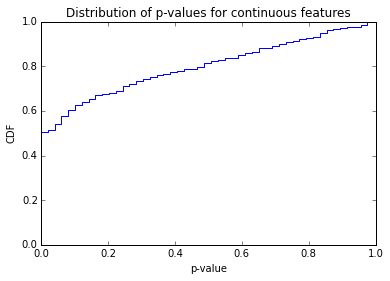

In [58]:
# plot distribution of p-values
import numpy as np
import statsmodels.api as sm # recommended import according to the docs
import matplotlib.pyplot as plt

sample = result['pval_a_equals_b']
ecdf = sm.distributions.ECDF(sample)

x = np.linspace(min(sample), max(sample))
y = ecdf(x)
plt.step(x, y); plt.xlabel('p-value'); plt.ylabel('CDF'); plt.title('Distribution of p-values for continuous features')
plt.show()

It appears from the above plot that approximately 50% of features have p-values close to zero and have strong discriminative power. Let's pick features with p-value < 0.2. This corresponds to selecting about 60% features.

In [59]:
continuous_feats = set(result['feature'][result['pval_a_equals_b'] < 0.2])

In [60]:
# NOW repeat test (for significant differences in the two groups) on binary features
indicatorDf.shape

(95149, 2543)

In [61]:
# step 0. remove extremely sparse (> 99.9% sparsity) indicator features
X = indicatorDf
total_training_count = X.shape[1]
counts = (X[0:total_training_count] != 0).sum() #X.sum(axis = 0)
THRESH = 0.001*X.shape[0] # i.e. allow no more than 99.9% sparsity
denseFeats = [feat for feat in list(X.columns) if counts[feat] >= THRESH]
len(denseFeats)


# permutation test to compare means in two groups xs, ys (more accurate than chi-squared when means are small)
def exact_mc_perm_test(xs, ys, nmc):
    n, k, k1, k2 = len(xs), 0, 0, 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    diff_un = (np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
        k1 += diff_un < (np.mean(zs[:n]) - np.mean(zs[n:]))
        k2 += diff_un >(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / nmc, k1 / nmc, k2 / nmc

# given a feature, perform permutation test to compare pop. means in success/failure sets
from scipy import stats
result = pd.DataFrame(columns = ('feature','meana', 'meanb','pval_a_equals_b','pval_a_greater_b' ,'pval_a_less_b'))
count = 0; count_sparse = 0
for feature in denseFeats:
    gp1 = X[pos_indices][feature]
    gp2 = X[neg_indices][feature]
    count_sparse += 1; 
    if count_sparse % 10 == 0:
        print(count_sparse) 
    # permuation test
    if gp1.sum() > 0.01*pos_count and gp2.sum() > 0.01*neg_count: #simulataneously remove sparse binary features
        p1, p2, p3 = exact_mc_perm_test(gp1, gp2, 10)
        result.loc[count, ] = [feature, gp1.mean(), gp2.mean(), p1, p3, p2]
        count += 1
        #if count % 10 == 0:
            #print(count)
# sort by p-values and save to file
result.sort('pval_a_equals_b', inplace = True)
result

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210


,feature,meana,meanb,pval_a_equals_b,pval_a_greater_b,pval_a_less_b
161,RFA_13_A1F,0.08096914,0.09573738,0,0,1
1,TCODE_1,0.2464278,0.2704163,0,0,1
4,STATE_CA,0.2186788,0.1800044,0,1,0
6,STATE_GA,0.02919859,0.03562888,0,0,1
7,STATE_IL,0.06108925,0.06768158,0,0,1
15,ZIP_92,0.05073514,0.03994686,0,1,0
16,MAILCODE_,0.9894388,0.9852414,0,1,0
19,RECINHSE_,0.9080555,0.9309123,0,0,1
20,RECINHSE_X,0.0919445,0.06908769,0,1,0
21,RECP3_,0.962104,0.9797498,0,0,1


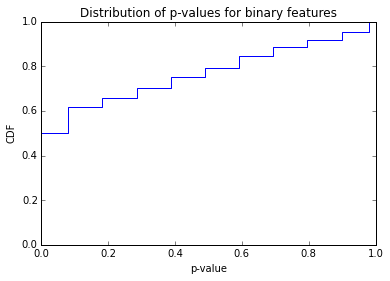

In [63]:
# plot distribution of p-values
import statsmodels.api as sm # recommended import according to the docs
sample = result['pval_a_equals_b']
ecdf = sm.distributions.ECDF(sample)

x = np.linspace(min(sample), max(sample))
y = ecdf(x)
plt.ylim(ymin = 0, ymax = 1)
plt.step(x, y); plt.xlabel('p-value'); plt.ylabel('CDF'); plt.title('Distribution of p-values for binary features')
plt.show()

It appears from the above plot that approximately 50% of binary features have p-values close to zero and have strong discriminative power. Let's pick features with p-value < 0.2. This corresponds to selecting about 60% features.

In [64]:
dense_feats = set(result['feature'][result['pval_a_equals_b'] < 0.2])
# prepare the data matrix temp (ASSEMBLE THE Full matrix)
temp = pd.concat([data, indicatorDf], axis = 1)
# drop the original categorical attributes (now mapped to 0/1 features)
for feature in data.columns: 
    if featureType[feature] == 'O':
        temp.drop(feature, axis = 1, inplace = True)

In [65]:
# FINALLY pick some features based on feature importances indicated by an unparameterized (to avoid overfitting) and hence, sub-optimal random forest 
# prepare X and y and fit a random-forest
y = temp['TARGET_B']
temp.drop(['TARGET_B', 'TARGET_D', 'CONTROLN'], axis = 1, inplace = True)
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier().fit(temp,y)

In [280]:
# print importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(temp.shape[1]):
    #print( (f + 1, temp.columns[indices[f]], importances[indices[f]]))
# Top-5
#(1, 'MINRDATE', 0.0042410808899738259)
#(2, 'RAMNTALL', 0.0039693010539639511)
#(3, 'AVGGIFT', 0.0036487276202799785)
#(4, 'POP902', 0.0036177825488045009)
#(5, 'OEDC5', 0.0036070480641193108)

In [69]:
# Obtain the set of features selected to be used for this model
full_set = (set(continuous_feats) | set(dense_feats) | set(list(temp.columns[indices[0:100]])))
full_set.remove('CONTROLN')
len(full_set)
# show few rows of final data matrix
temp[list(full_set)].head()

,PETS_,HC6,HV1,RFA_2_L3E,DW8,IC12,RP4,MARR2,RFA_5_A1F,RFA_4_F1F,...,ADATE_24,HC7,RECINHSE_X,CLUSTER_40,WALKER_Y,TCODE_0,RDATE_14,HIT,RFA_2A_F,CATLG_Y
0,1,31,479,0,7,0,73,7,0,0,...,9406,54,0,0,0,1,9507,0,0,0
1,1,97,5468,0,0,13,94,4,0,0,...,9406,99,0,0,0,0,0,16,0,0
2,1,50,497,0,3,0,44,9,0,0,...,9406,69,0,0,0,0,9506,2,0,0
3,1,39,1000,0,0,0,34,9,0,0,...,9406,45,0,0,0,1,9508,2,0,0
4,1,6,576,0,0,0,83,17,0,0,...,9406,33,1,0,1,1,9506,60,1,1


### Step 6. Feature Engineering


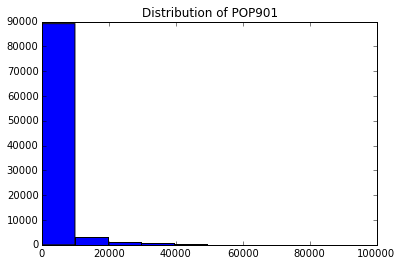

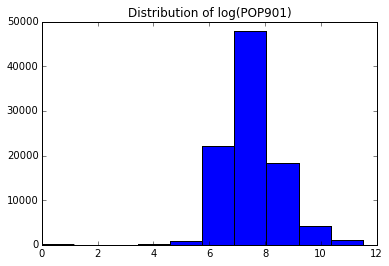

94484

In [72]:
# CHECK distribution of population variable (expect to be long-tailed and apply log-transform to normalize)
Y = data['POP901']
q = list((data['POP901']))
q = [x for x in q if x > 0]
# distribution of donation_amount
plt.hist(q)
plt.title('Distribution of POP901')
plt.show()
# perform log-transformation
q = np.log(q)
plt.hist(q)
plt.title('Distribution of log(POP901)')
plt.show()
len(q)

In [73]:
logT = lambda x: np.log(1 + x if x is not None and not np.isnan(x) else 1)
temp['POP901'] = data['POP901'].apply(lambda x: logT(x))
temp['POP902'] = data['POP902'].apply(lambda x: logT(x))
temp['POP903'] = data['POP903'].apply(lambda x: logT(x))

In [74]:
X = temp[list(full_set)]

In [75]:
# Check feature-feature similarities
from matplotlib.pyplot import imshow 

# compute similarity matrix
diagonal = X.apply(lambda x: 1/np.sqrt(sum(x**2)), axis = 0)
diagonal = np.diag(diagonal)
diagonal[(~np.isfinite(diagonal))] = 1
sim_mat_raw = diagonal.dot(X.transpose().dot(X)).dot(diagonal)
# plot similarity matrix
mat = sim_mat_raw; feats = X.columns
imshow(np.array(mat), cmap=plt.cm.jet,
interpolation='nearest')
width = len(mat)
height = len(mat)
#colorbar
plt.colorbar(label = "sim")
plt.xticks(range(height), feats, fontsize = 4, rotation = -270)
plt.yticks(range(width), feats, fontsize = 4)
#plt.xlabel('Variable',fontweight='bold')
#plt.ylabel('Variable',fontweight='bold')
plt.title('Cosine Similarity',fontweight='bold')
#  save the figure here with:
plt.clf(); plt.close()

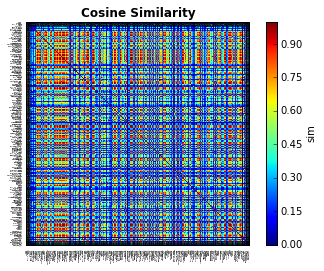

In [77]:
# plot similarity matrix
mat = sim_mat_raw; feats = X.columns
plt.imshow(np.array(mat), cmap=plt.cm.jet,
interpolation='nearest')
width = len(mat)
height = len(mat)
#colorbar
plt.colorbar(label = "sim")
plt.xticks(range(height), feats, fontsize = 2, rotation = -270)
plt.yticks(range(width), feats, fontsize = 2)
#plt.xlabel('Feature Index',fontweight='bold')
#plt.ylabel('Feature Index',fontweight='bold')
plt.title('Cosine Similarity',fontweight='bold')
#  save the figure here with:

The above similaity matrix exposes that there is  potential to reduce dimensinality and capture  feature-feature interactions.

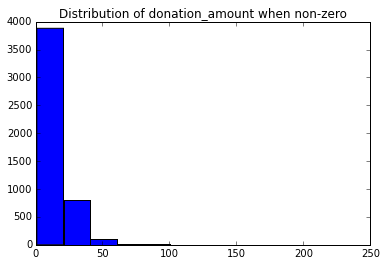

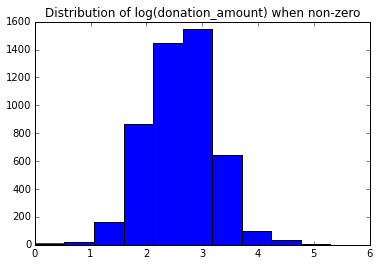

4829

In [78]:
# CHECK DISTRIBUTION OF OUTCOME VARIABLE
Y = data['TARGET_B']
A = data['TARGET_D']
donation_amount = list((A))
donation_amount = [x for x in donation_amount if x > 0]
# distribution of donation_amount
plt.hist(donation_amount)
plt.title('Distribution of donation_amount when non-zero')
plt.show()
# perform log-transformation
donation_amount = np.log(donation_amount)
plt.hist(donation_amount)
plt.title('Distribution of log(donation_amount) when non-zero')
plt.show()
len(donation_amount)

It looks like the raw target variable (*donation_amount*) seems to follow a long-tailed distribution. It maybe useful to transform Y via a log-transform and squish down the tail. 

In general, to model a nice linear functional relationship Y | X, it is nice to have Y normally distributed. Otherwise, linear regression may seem to fit a linear function with high R-squared but in **reality** either 1) there is no linear relationship or 2) the model fit is sub-optimal due to presence of outliers (long-tailed distribution).  See discussion here: https://en.wikipedia.org/wiki/Correlation_and_dependence#/media/File:Anscombe%27s_quartet_3.svg

In [1]:
# SAVE DATA TO FILE
import pandas as pd, numpy as np
X.to_csv("X.csv", index = False) if dir().count('X') > 0 else None
X = pd.read_csv("X.csv")
pd.DataFrame(Y).to_csv("Y.csv", index = False) if dir().count('Y') > 0 else None
Y = pd.read_csv("Y.csv")
Y = np.ravel(Y)
pd.DataFrame(A).to_csv("A.csv", index = False) if dir().count('A') > 0 else None
A = pd.read_csv("A.csv")
A = np.ravel(A)

In [2]:
print(Y.shape)
print(X.shape)
print(A.shape)

(95149,)
(95149, 427)
(95149,)


### Step 7. MODELING : Model 1 (Predict 0/1 Response)
data appears to be heavily imbalanced and hence, we may want to oversample.
treat this as a 2-step process: first try to model classification and then, regression
* Model 1: Predict positive response probability
* Model 2: Predicting Amounts

In [3]:
# load packages
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV 
from sklearn import svm
from sklearn import grid_search
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics.scorer import make_scorer
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import brier_score_loss

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import mixture

#do bayesian optimization for hyper-parameter search
from sklearn.cross_validation import cross_val_score
# clone https://github.com/fmfn/BayesianOptimization (other : http://hyperopt.github.io/hyperopt/)
from  BayesianOptimization.bayes_opt import BayesianOptimization

#DL
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd
import matplotlib
#from cycler import cycler
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow 
import time
import matplotlib, matplotlib.pyplot as plt
%matplotlib inline

#curve fit
from scipy.optimize import curve_fit
from sklearn.isotonic import IsotonicRegression
from sklearn import preprocessing

Using Theano backend.


In [18]:
# BINARY CLASSIFICATION PROBLEM
# optimize for auc score

# scorer for cross-validation 
def precisionAtK(y_true, y_pred, k = 0.25):
    print('.', end = "")
    y_pred = y_pred[:,1] # pos class probability
    return  metrics.roc_auc_score(y_true, y_pred) 


# helper function to print metrics
def printMetrics(y_test, predicted, probs):
    print(metrics.accuracy_score(y_test, predicted))
    auc = (metrics.roc_auc_score(y_test, probs[:, 1]))
    print('auc:' + str(auc))
    print('conf_mat:' + str(metrics.confusion_matrix(y_test, predicted)))
    print('met:' + str(metrics.classification_report(y_test, predicted)))
    return auc


# k nearest neighbours
def kNearestNeighbours(X_train, y_train, X_test, state):
    print("training kNN... \n");
    # set state
    np.random.seed(state)
    knn = KNeighborsClassifier(algorithm = 'auto', weight = 'distance')
    # define a search space
    space = {'n_neighbors' : (1,100), 
             'leaf_size' : (10,50), 
             'p' : (1,3)}
    # minimize the objective over the space
    best = BayesianOptimization (lambda n_neighbors, leaf_size, p : 
                                 np.nanmean(cross_val_score(
            KNeighborsClassifier(n_neighbors = int(n_neighbors),
                                 leaf_size = int(leaf_size),
                                 p = int(p),
                                 algorithm = 'auto'),
                                 X_train, y_train, scoring=make_scorer(precisionAtK, needs_proba = True), 
                cv=StratifiedKFold(y_train, n_folds=3, shuffle=True, random_state=state))), space) # X_, y_, scoring=make_scorer(precisionAtK), cv=5).mean(), space) #
    best.maximize()
    print(best.res['max']['max_params'])
    # obtain best fit
    best_fit = KNeighborsClassifier(n_neighbors = int(best.res['max']['max_params']['n_neighbors']),
                                   leaf_size = int(best.res['max']['max_params']['leaf_size']),
                                   p = best.res['max']['max_params']['p'], 
                                   algorithm = "auto")
    # select the best estimator
    knn_cv = best_fit.fit(X_train, y_train)
    # predict class labels for the test set
    predicted = knn_cv.predict(X_test)
    # generate class probabilities
    probs_knn = knn_cv.predict_proba(X_test)
    return predicted, probs_knn, knn_cv



#same as OLD
def logisticRegression(X_train, y_train, X_test, state):
    print("training LR... \n");    
    # fit model
    #lr_cv = LogisticRegressionCV(penalty=['l1','l2'], class_weight = "balanced", solver='liblinear', Cs=np.linspace(1e-4, 3, 100), refit=True, random_state = state, scoring = make_scorer(precisionAtK), cv = 5)
    Cs = np.linspace(1e-5, 3, 10)#
    lr = LogisticRegression(dual = False, class_weight = "balanced", solver='liblinear', random_state = state)
    lr_cv = grid_search.GridSearchCV(estimator = lr, param_grid = dict(C = Cs, penalty = ['l1', 'l2']), scoring = make_scorer(precisionAtK, needs_proba = True), 
                                     cv = StratifiedKFold(y_train, n_folds=3, shuffle=True, random_state=state))
    lr_cv = lr_cv.fit(X_train, y_train)
    # check which value of C was selected
    print(lr_cv.best_params_['C']) 
    # select the best estimator
    lr_cv = lr_cv.best_estimator_.fit(X_train, y_train)
    # check number of coefficients selected
    print(np.count_nonzero(lr_cv.coef_))  #  non-zero coefficients 
    # check features and their coeffs.
    #print([ (x,y) for (x,y) in zip(X_train.columns[np.nonzero(lr_cv.coef_)[1]], lr_cv.coef_[0][np.nonzero(lr_cv.coef_[0])[0]])])
    # predict class labels for the test set
    predicted = lr_cv.predict(X_test)
    # generate class probabilities
    probs_lr = lr_cv.predict_proba(X_test)
    return predicted, probs_lr, lr_cv



def suppVector(X_train, y_train, X_test, state):
    print("training SVM... \n");    
    #Cs = np.linspace(1e-4, 100, 10)#np.logspace(0,1,10) for linear [0,1], for rbf [0,100]
    # slow
    Cs = [0.1, 1]
    sv = svm.SVC(class_weight= "balanced",  random_state=state, probability = True)
    kernel_choices = ['rbf'] #['linear','poly', 'rbf','sigmoid'] ... tuning always picks 'rbf' as the best kernel (make it default to save time)
    sv_cv = grid_search.GridSearchCV(estimator = sv, param_grid = dict(C = Cs, kernel = kernel_choices), scoring = make_scorer(precisionAtK, needs_proba = True), 
                                     cv = StratifiedKFold(y_train, n_folds=3, shuffle=True, random_state=state))
    sv_cv = sv_cv.fit(X_train, y_train)
    print(sv_cv.best_params_)
    C_best = sv_cv.best_params_['C']
    sv_cv = sv_cv.best_estimator_.fit(X_train, y_train) # or sv.fit(X_train, y_train)
    # check which value of C was selected
    #print('C:' + str(C_best))  
    # predict class labels for the test set
    predicted = sv_cv.predict(X_test)
    # generate class probabilities
    probs_svm = sv_cv.predict_proba(X_test)
    return predicted, probs_svm, sv_cv




# bayesian optimization for hyperparameter-tuning of random forest
def randomForest(X_train, y_train, X_test, state):
    print("training randomForest... \n");    
    # set state
    np.random.seed(state)
    # define a search space
    space = {'max_depth': (1,10),
             'max_features': (0.1, 0.999),
             'min_samples_split': (1,20),
             'min_samples_leaf': (1,20),
             'n_estimators': (10, 100)
    }
    # minimize the objective over the space
    best = BayesianOptimization (lambda max_depth, min_samples_split, max_features, min_samples_leaf, n_estimators : 
                                 np.nanmean(cross_val_score(
            RandomForestClassifier(n_estimators = int(n_estimators),class_weight = "balanced", random_state = state,
                                   max_depth = int(max_depth),
                                   max_features = min(max_features, 0.999), 
                                   min_samples_split = int(min_samples_split), 
                                   min_samples_leaf = int(min_samples_leaf), 
                                   criterion = "gini"),
                                 X_train, y_train, scoring=make_scorer(precisionAtK, needs_proba = True), 
                cv=StratifiedKFold(y_train, n_folds=3, shuffle=True, random_state=state))), space) # X_, y_, scoring=make_scorer(precisionAtK), cv=5).mean(), space) #
    best.maximize()
    print(best.res['max']['max_params'])
    # obtain best fit
    best_fit = RandomForestClassifier(n_estimators = int(best.res['max']['max_params']['n_estimators']),class_weight = "balanced", random_state = state,
                                   max_depth = int(best.res['max']['max_params']['max_depth']),
                                   max_features = best.res['max']['max_params']['max_features'], 
                                   min_samples_split = int(best.res['max']['max_params']['min_samples_split']), 
                                   min_samples_leaf = int(best.res['max']['max_params']['min_samples_leaf']), 
                                   criterion = "gini")
    rf_cv  = best_fit.fit(X_train, y_train)
    # predict class labels for the test set
    predicted = rf_cv.predict(X_test)
    # generate class probabilities
    probs_rf = rf_cv.predict_proba(X_test)
    # print importances
    importances = rf_cv.feature_importances_
    indices = np.argsort(importances)[::-1]
    # Print the feature ranking
    #print("Feature ranking:")
    #for f in range(X.shape[1]):
    #    print( (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
    return predicted, probs_rf, rf_cv 


# bayesian optimization for hyperparameter-tuning of "extremely randomized trees" P. Geurts, D. Ernst., and L. Wehenkel, “Extremely randomized trees”, Machine Learning, 63(1), 3-42, 2006.
# key = splits are at ranodm (compare to information gain optimization in random-forest) = > less over-fitting
def extremeTrees(X_train, y_train, X_test, state):
    print("training ExtraTrees... \n");    
    # set state
    np.random.seed(state)
    # define a search space
    space = {'max_depth': (1,10),
             'max_features': (0.1, 0.999),
             'min_samples_split': (1,20),
             'min_samples_leaf': (1,20),
             'n_estimators': (10, 100)
    }
    # minimize the objective over the space
    best = BayesianOptimization (lambda max_depth, min_samples_split, max_features, min_samples_leaf, n_estimators : 
                                 np.nanmean(cross_val_score(
            ExtraTreesClassifier (n_estimators = int(n_estimators),class_weight = "balanced", random_state = state,
                                   max_depth = int(max_depth),
                                   max_features = min(max_features, 0.999), 
                                   min_samples_split = int(min_samples_split), 
                                   min_samples_leaf = int(min_samples_leaf), 
                                   criterion = "gini"),
                                 X_train, y_train, scoring=make_scorer(precisionAtK, needs_proba = True), 
                cv=StratifiedKFold(y_train, n_folds=3, shuffle=True, random_state=state))), space) # X_, y_, scoring=make_scorer(precisionAtK), cv=5).mean(), space) #
    best.maximize()
    print(best.res['max']['max_params'])
    # obtain best fit
    best_fit = ExtraTreesClassifier (n_estimators = int(best.res['max']['max_params']['n_estimators']),class_weight = "balanced", random_state = state,
                                   max_depth = int(best.res['max']['max_params']['max_depth']),
                                   max_features = best.res['max']['max_params']['max_features'], 
                                   min_samples_split = int(best.res['max']['max_params']['min_samples_split']), 
                                   min_samples_leaf = int(best.res['max']['max_params']['min_samples_leaf']), 
                                   criterion = "gini")
    et_cv  = best_fit.fit(X_train, y_train)
    # predict class labels for the test set
    predicted = et_cv.predict(X_test)
    # generate class probabilities
    probs_et = et_cv.predict_proba(X_test)
    return predicted, probs_et, et_cv 



# extreme gradient boosting (uses regularization to control over-fitting)
# https://www.quora.com/What-is-the-difference-between-the-R-gbm-gradient-boosting-machine-and-xgboost-extreme-gradient-boosting
# git clone --recursive https://github.com/dmlc/xgboost.git  && cd xgboost && sh build.sh && cd python-package && python3 setup.py install --user   
def extremeBoosting(X_train, y_train, X_test, state):
    print("training xgboost... \n");    
    # set state
    np.random.seed(state)
    # define a search space
    space = {'max_depth': (2, 10),
              'learning_rate': (2/300, 10/20),
              'n_estimators': (20, 300),
              'gamma': (0, 5),
              'min_child_weight': (1, 20),
              'max_delta_step': (0, 10),
              'subsample': (0.3, 1.0),
              'colsample_bytree' : (max(0.3, 2/X_train.shape[1]), 1.0) if X_train.shape[1] >  10 else (1.0, 1.0)
            }
    # balance classes
    weight = sum(y_train == 0)/ sum(y_train == 1) #https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    # minimize the objective over the space
    best = BayesianOptimization (lambda max_depth,learning_rate,n_estimators,gamma,min_child_weight,max_delta_step,subsample,colsample_bytree,
                  silent =True,
                  nthread = -1,
                  seed = state: 
                                 np.nanmean(cross_val_score(
                XGBClassifier(max_depth = int(max_depth),
                             learning_rate = learning_rate,
                             n_estimators = int(n_estimators),
                             silent = silent,
                             nthread = nthread,
                             gamma = gamma,
                             min_child_weight = int(min_child_weight),
                             max_delta_step = max_delta_step,
                             subsample = subsample,
                             colsample_bytree = colsample_bytree,
                             seed = seed,
                             scale_pos_weight = weight,
                             objective = "binary:logistic"),
                             X_train, y_train, scoring=make_scorer(precisionAtK, needs_proba = True), 
                cv=StratifiedKFold(y_train, n_folds=3, shuffle=True, random_state=state))), space) # X_, y_, scoring=make_scorer(precisionAtK), cv=5).mean(), space) #
    best.maximize()
    print(best.res['max']['max_params'])
    # obtain best fit
    best_fit = XGBClassifier (n_estimators = int(best.res['max']['max_params']['n_estimators']), silent = True, nthread = -1, seed = state,
                                   max_depth = int(best.res['max']['max_params']['max_depth']),
                                   learning_rate = best.res['max']['max_params']['learning_rate'], 
                                   gamma = (best.res['max']['max_params']['gamma']), 
                                   min_child_weight = (best.res['max']['max_params']['min_child_weight']), 
                                   max_delta_step = (best.res['max']['max_params']['max_delta_step']), 
                                   subsample = (best.res['max']['max_params']['subsample']), 
                                   colsample_bytree = best.res['max']['max_params']['colsample_bytree'],
                                   scale_pos_weight = weight, objective = "binary:logistic")
    xgb_cv  = best_fit.fit(X_train, y_train)
    # sorted(xgb_cv.booster().get_fscore().items(), key = lambda x: x[1])
    # predict class labels for the test set
    predicted = xgb_cv.predict(X_test)
    # generate class probabilities
    probs_xgb = xgb_cv.predict_proba(X_test)
    return predicted, probs_xgb, xgb_cv 




# bayesian optimization for hyperparameter-tuning of one/two layer NN [tune hidden neurons, batch size and epoch number]
# add dropout regularization as per https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf
def returnNNModelObjectwDropout(inputSize, nneurons1, nneurons2, dropout_ratio_input, dropout_ratio_hidden, state):
    # set state
    np.random.seed(state)
    model = Sequential()
    #model.add(Dropout(float(dropout_ratio_input), input_shape=(inputSize,)))
    model.add(Dense(nneurons1, input_dim=(inputSize), init='uniform', activation='tanh'))
    model.add(Dropout(float(dropout_ratio_hidden), input_shape=(nneurons1,)))
    #model.add(Dense(nneurons2, init='normal', activation='tanh'))
    model.add(Dense(1, init='uniform', activation='sigmoid')) # try dropout layers
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # only 'accuracy' supported currently, categorical_crossentropy() if tertiary
    # print model.summary()
    return model


def buildPipelinewDropout(inputSize, nneurons1, nneurons2, dropout_ratio_input, dropout_ratio_hidden,  epoch, batch, state):
    # set state
    np.random.seed(state)
    # Two-layer NN
    # create model
    model = lambda : returnNNModelObjectwDropout(inputSize, nneurons1, nneurons2, dropout_ratio_input, dropout_ratio_hidden, state) # kerasclassifer takes function as input
    # build pipeline
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('mlp', KerasClassifier(build_fn=model, nb_epoch=epoch, batch_size=batch, verbose = 0))) #verbose = 0
    pipeline = Pipeline(estimators)
    return pipeline


# bayesian optimization for hyperparameter-tuning of one/two layer NN [tune hidden neurons, batch size and epoch number]
# add dropout regularization as per https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf
def layerNNwDropout(X_train, y_train, X_test, state):
    print("training NN... \n");    
    # set state
    np.random.seed(state)
    inputDim = X_train.shape[1]
    # define a search space
    space = {'nneurons1': (min(5, inputDim),inputDim),
             'dropout_ratio_hidden': (0.0, 0.4),
             'epoch': (1, 100),
             'batch':(1, 200),
    }
    #             'dropout_ratio_input': (0.0, 0.2),
    print("space:" + str(space))
    #             'nneurons2': (5,30),
    # minimize the objective over the space
    best = BayesianOptimization (lambda nneurons1, dropout_ratio_hidden, epoch, batch : 
                                 np.nanmean(cross_val_score(
            buildPipelinewDropout(inputDim, int(nneurons1), int(0), 0, float(dropout_ratio_hidden), int(epoch), int(batch), state),
                                 X_train, y_train, scoring=make_scorer(precisionAtK, needs_proba = True), 
                cv=StratifiedKFold(y_train, n_folds=3, shuffle=True, random_state=state))), space) # X_, y_, scoring=make_scorer(precisionAtK), cv=5).mean(), space) #
    best.maximize()
    print(best.res['max']['max_params'])
    # obtain best fit #float(best.res['max']['max_params']['dropout_ratio_input'])
    best_fit = buildPipelinewDropout(inputDim, int(best.res['max']['max_params']['nneurons1']), 0, 0, 
                             float(best.res['max']['max_params']['dropout_ratio_hidden']), int(best.res['max']['max_params']['epoch']),
                             int(best.res['max']['max_params']['batch']), state) 
    nn_cv  = best_fit.fit(X_train, y_train)
    # predict class labels for the test set
    predicted = nn_cv.predict(X_test)
    # generate class probabilities
    probs_nn = nn_cv.predict_proba(X_test)
    return predicted, probs_nn, nn_cv




# bayesian optimization for hyperparameter-tuning of random forest
def gradientBoosting(X_train, y_train, X_test, state):
    print("training gradientBoosting... \n");
    # set state
    np.random.seed(state)
    # define a search space
    space = {'max_depth': (1,10),
             'max_features': (0.1, 0.999),
             'min_samples_split': (1,20),
             'min_samples_leaf': (1,20),
             'n_estimators': (10, 100)
    }
    # minimize the objective over the space
    best = BayesianOptimization (lambda max_depth, min_samples_split, max_features, min_samples_leaf, n_estimators : 
                                 np.nanmean(cross_val_score(
            GradientBoostingClassifier(n_estimators = int(n_estimators), random_state = state,
                                   max_depth = int(max_depth),
                                   max_features = min(max_features, 0.999), 
                                   min_samples_split = int(min_samples_split), 
                                   min_samples_leaf = int(min_samples_leaf)),
                                 X_train, y_train, scoring=make_scorer(precisionAtK, needs_proba = True), 
                cv=StratifiedKFold(y_train, n_folds=3, shuffle=True, random_state=state))), space) # X_, y_, scoring=make_scorer(precisionAtK), cv=5).mean(), space) #
    best.maximize()
    print(best.res['max']['max_params'])
    # obtain best fit
    best_fit = GradientBoostingClassifier(n_estimators = int(best.res['max']['max_params']['n_estimators']), random_state = state,
                                   max_depth = int(best.res['max']['max_params']['max_depth']),
                                   max_features = best.res['max']['max_params']['max_features'], 
                                   min_samples_split = int(best.res['max']['max_params']['min_samples_split']), 
                                   min_samples_leaf = int(best.res['max']['max_params']['min_samples_leaf']))
    rf_cv  = best_fit.fit(X_train, y_train)
    # predict class labels for the test set
    predicted = rf_cv.predict(X_test)
    # generate class probabilities
    probs_rf = rf_cv.predict_proba(X_test)
    return predicted, probs_rf, rf_cv


def rankOrdered(array):
    order = array.argsort()
    ranked = np.empty(len(array))
    ranked[order] = np.linspace(0, len(array), len(array)+1)
    return ranked

def ensembleModelCalculation(probs_lr, probs_svm, probs_rf, probs_gb, probs_nn = 0.5, probs_erf = 0.5, probs_egb = 0.5, probs_knn = 0.5):
    rank_lr = rankOrdered(probs_lr)
    rank_svm = rankOrdered(probs_svm)
    rank_rf = rankOrdered(probs_rf)
    rank_gb = rankOrdered(probs_gb)
    rank_erf = rankOrdered(probs_erf)
    rank_egb = rankOrdered(probs_egb)
    rank_nn = rankOrdered(probs_nn)
    rank_knn = rankOrdered(probs_knn)
    # allocate weights if model is predicting something
    w_lr = 0 if np.all(probs_lr == 0.5) else 1
    w_svm = 0 if np.all(probs_svm == 0.5) else 1
    w_rf = 0 if np.all(probs_rf == 0.5) else 1
    w_gb = 0 if np.all(probs_gb == 0.5) else 1 # assign equal weights, since rf and gb are similar
    w_erf = 0 if np.all(probs_erf == 0.5) else 1
    w_egb = 0 if np.all(probs_egb == 0.5) else 1 # assign equal weights, since rf and gb are similar
    w_nn = 0 if np.all(probs_nn == 0.5) or np.all(probs_nn == 0) else 1
    w_knn = 0 if np.all(probs_knn == 0.5) or np.all(probs_knn == 0) else 1
    w_tot = w_lr + w_svm + w_rf + w_gb + w_nn + w_erf + w_egb + w_knn
    # average and normalize the ranks to prob_score in [0,1]
    return (w_lr*rank_lr + w_svm*rank_svm + w_rf*rank_rf + w_gb*rank_gb + w_nn*rank_nn + w_erf*rank_erf + w_egb*rank_egb + w_knn*rank_knn)/(w_tot)/len(rank_lr)


def ensembleModel(X_train, y_train, X_test, state):
    print("training xgboost... \n"); predicted, probs_egb, obj = extremeBoosting(X_train, y_train, X_test, state)
    print("training kNearestNeighbours... \n"); predicted, probs_knn, obj = kNearestNeighbours(X_train, y_train, X_test, state)
    print("training ExtraTrees... \n"); predicted, probs_erf, obj = extremeTrees(X_train, y_train, X_test, state)
    print("training logisticRegression... \n"); predicted, probs_lr, obj = logisticRegression(X_train, y_train, X_test, state)
    print("training randomForest... \n"); predicted, probs_rf, obj = randomForest(X_train, y_train, X_test, state)
    print("training suppVector... \n"); predicted, probs_svm, obj = suppVector(X_train, y_train, X_test, state)
    print("training gradientBoosting... \n"); predicted, probs_gb, obj = gradientBoosting(X_train, y_train, X_test, state)
    print("training layerNNwDropout... \n"); predicted, probs_nn, obj = layerNNwDropout(X_train, y_train, X_test, state)
    #probs_nn = np.zeros([X_test.shape[0],2]) # maybe turn-off NN for now, not performing well. n/p not large enough. Decide to use with or without dropout
    probs_ensemble = ensembleModelCalculation(probs_lr[:,1], probs_svm[:,1], probs_rf[:,1], probs_gb[:,1], probs_nn[:,1], probs_erf[:,1], probs_egb[:,1], probs_knn[:,1])
    result = np.empty(shape = probs_lr.shape)
    result[:,1] = probs_ensemble
    # populate a placeholder for predicted (not used)
    predicted = np.zeros(result.shape[0])
    baseline = sum(y_train)/len(y_train)
    predicted[probs_ensemble > (1-baseline)] = 1 # label top-b % as successes where b is baseline seed->seriesA rate %
    return predicted, result, None


# if want to try dimensionality reduction
def spectralClustering(X):
    # build similarity matrix
    diagonal = X.apply(lambda x: 1/np.sqrt(sum(x**2)), axis = 0)
    diagonal = np.diag(diagonal)
    diagonal[(~np.isfinite(diagonal))] = 1
    sim_mat_raw = diagonal.dot(X.transpose().dot(X)).dot(diagonal)
    #plotSim(sim_mat_raw, X.columns)
    # decompose the feature-feature similarity matrix via pca and retain top K components (contains ~ 80-85% of energy)
    # find optimal K
    pca = PCA()
    pca.fit(sim_mat_raw)
    explainedVar = np.cumsum(pca.explained_variance_ratio_)
    n_comps = next(x for x in range(len(explainedVar)) if explainedVar[x] > 0.999)
    print(n_comps)
    #Looking at above plot I'm taking 27 
    pca = PCA(n_components=n_comps)
    pca.fit(sim_mat_raw)
    feats_vec = pca.fit_transform(sim_mat_raw)
    # cluster the feature-vectors and obtain "soft" cluster memberships
    # find optimal C
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, feats_vec.shape[1])
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a mixture of Gaussians with EM
            gmm = mixture.GMM(n_components=n_components, covariance_type=cv_type)
            gmm.fit(feats_vec)
            bic.append(gmm.bic(feats_vec))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    # use "soft" cluster-memberships as feature-vectors
    print(best_gmm)
    mapping = best_gmm.predict_proba(feats_vec)
    return mapping

#### Split data into training and testing
Build a balanced training-set by undersampling the negative examples.

In [5]:
state  = 0
np.random.seed(state)
sam = np.random.choice(range(X.shape[0]), 10000)
# build a balanced training-set : 1) All positive examples 2) Additionally, show same amount of negative examples to the model 
sam = list(X.index[Y == 1]) + list(np.random.choice(list(X.index[Y == 0]), sum(Y)))
X_train, X_test, y_train, y_test = train_test_split(X.loc[sam,], Y[sam], test_size=0.3, random_state=state)
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

###Regularization
It is important to avoid overfitting and let the model select a small set of strong predictors. Since, we only select sample of negative examples and feature space is still quite high-dimensional.
Using L1 penalty for feature-selection, leads to sparse coefficient vector (think of it as an extension of L0 penalty  i.e. number of non-zero coefficients). The gradient descent penalizes all coefficients at same rate. On the other hand, L2 leads to dense feature vectors because it really cares about minimizing big-coefficients (the gradient descent tries to minimize large coefficients at higher-rate).

All models tried have some flavor of regularization. To speed-up tuning regularization and other hyperparameters we can use Bayesian Optimization (performs a greedy search in a high-dimensional hyperparameter space).

###Weight Balancing
All classification models have some notion of class_weights to account for class imbalance.

###Model Evaluation

Evaluation metrics:
* AUC, Precision-Recall for classification
* R-squared for regression
* Profit at top K (business use-case metric) i.e. we can quantify performance of the predictions in terms of $s

### Model Selection

In [10]:
# COMPARE MODELS
# try spectral clustering to add latent features that capture non-linear interactions between features
#mapping = spectralClustering(X_train)
#X_train_lat = X_train.dot(mapping)
#X_test_lat = X_test.dot(mapping)
#X_train = pd.concat([X_train, X_train_lat], axis = 1)
#X_test = pd.concat([X_test, X_test_lat], axis = 1)
# 
print('START Modeling...')
# Initialize an array to store predictions from each method
probs = {}
# LOGISTIC REGRESSION
predicted, probs_lr, lr_cv = logisticRegression(X_train, y_train, X_test, state); 
probs['LR'] = probs_lr[:,1]
# generate evaluation metrics
auc = printMetrics(y_test, predicted, probs_lr)
# RANDOM FOREST MODEL
predicted, probs_rf, rf_cv = randomForest(X_train, y_train, X_test, state);
probs['RF'] = probs_rf[:,1]
# generate evaluation metrics
auc = printMetrics(y_test, predicted, probs_rf)
# Gradient Boosting
predicted, probs_gb, gb_cv = gradientBoosting(X_train, y_train, X_test, state);
probs['GB'] = probs_gb[:,1]
# generate evaluation metrics
auc = printMetrics(y_test, predicted, probs_gb)
# E. RANDOM FOREST MODEL
predicted, probs_erf, erf_cv = extremeTrees(X_train, y_train, X_test, state); 
probs['ERF'] = probs_erf[:,1]
# generate evaluation metrics
auc = printMetrics(y_test, predicted, probs_erf)
# E. Gradient Boosting
predicted, probs_egb, egb_cv = extremeBoosting(X_train, y_train, X_test, state);
probs['EGB'] = probs_egb[:,1]
# generate evaluation metrics
auc = printMetrics(y_test, predicted, probs_egb)
# Neural Net
predicted, probs_nn, nn_cv = layerNNwDropout(X_train, y_train, X_test, state); 
probs['NN'] = probs_nn[:,1]
# generate evaluation metrics
auc = printMetrics(y_test, predicted, probs_nn)
# kNN
predicted, probs_knn, knn_cv = kNearestNeighbours(X_train, y_train, X_test, state); 
probs['kNN'] = probs_knn[:,1]
# generate evaluation metrics
auc = printMetrics(y_test, predicted, probs_knn)
# SUPPORT VECTOR MACHINES
predicted, probs_svm, sv_cv = suppVector(X_train, y_train, X_test, state); 
probs['SVM'] = probs_svm[:,1]
# generate evaluation metrics
auc = printMetrics(y_test, predicted, probs_svm)
# ENSEMBLE EQUAL WEIGHTs MODEL
probs_ensemble = ensembleModelCalculation(probs_lr[:,1], probs_svm[:,1], probs_rf[:,1], probs_gb[:,1], probs_nn[:,1], probs_erf[:,1], probs_egb[:,1], probs_knn[:,1]) #
######################################

START Modeling...
training LR... 

............................................................0.333342222222
158
0.590062111801
auc:0.623376815128
conf_mat:[[864 590]
 [598 846]]
met:             precision    recall  f1-score   support

        0.0       0.59      0.59      0.59      1454
        1.0       0.59      0.59      0.59      1444

avg / total       0.59      0.59      0.59      2898

training randomForest... 

Initialization
------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   min_samples_leaf |   min_samples_split |   n_estimators | 
...    1 | 00m08s |    0.61670 |      6.8130 |         0.1783 |            16.0428 |             13.1585 |        98.0757 | 
...    2 | 00m03s |    0.61500 |      4.9383 |         0.1182 |            11.0490 |              3.7237 |        81.9243 | 
...    3 | 00m27s |    0.60713 |      9.0260 |         0.8485 |   

KeyboardInterrupt: 

In [19]:
# continued after keyboard interrupt

training kNN... 

Initialization
-----------------------------------------------------------------------
 Step |   Time |      Value |   leaf_size |   n_neighbors |         p | 
...    1 | 00m17s |    0.59748 |     47.0239 |       54.9434 |    2.9273 | 
...    2 | 00m24s |    0.59642 |     12.8414 |       42.9418 |    1.7669 | 
...    3 | 00m28s |    0.60244 |     13.4852 |       64.9435 |    2.5835 | 
...    4 | 00m27s |    0.59540 |     10.8087 |       44.3211 |    2.0578 | 
...    5 | 00m16s |    0.60577 |     43.3048 |       89.2855 |    2.1361 | 
Bayesian Optimization
-----------------------------------------------------------------------
 Step |   Time |      Value |   leaf_size |   n_neighbors |         p | 
...    6 | 00m19s |    0.60484 |     37.0253 |       86.8005 |    2.2295 | 
...    7 | 00m18s |    0.60658 |     38.2266 |       92.0496 |    2.0059 | 
...    8 | 00m18s |    0.60641 |     39.4162 |       97.5429 |    2.1003 | 
...    9 | 00m17s |    0.60618 |     43.1064 | 

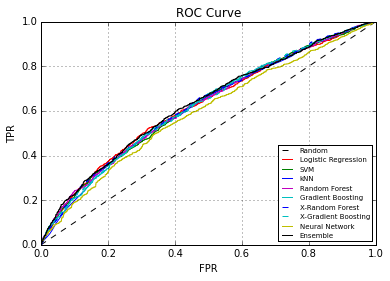

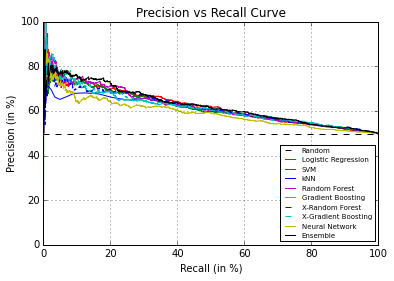

In [21]:
# GENERATE PLOTS -> ROC, Recall-Precision
# ROC plot
%matplotlib inline
styles = ['-r', '-g', '-b', '-m', '-c', '--b', '--c','-y', '-k', ':k']
plt.xlim([0,1]); plt.ylim([0,1])
plt.plot([0,1], [0,1], '--k', label = "Random")
fpr = np.linspace(0,1,21)
b = sum(y_test)/len(y_test)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve")
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs_lr[:, 1]) #np.random.rand(y_test.shape[0]) for a random model
plt.plot(fpr, tpr, styles[0], label = "Logistic Regression")
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs_svm[:, 1])
plt.plot(fpr, tpr, styles[1],label = "SVM")
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs_knn[:, 1])
plt.plot(fpr, tpr, styles[2],label = "kNN")
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs_rf[:, 1])
plt.plot(fpr, tpr, styles[3],label = "Random Forest") 
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs_gb[:, 1])
plt.plot(fpr, tpr, styles[4],label = "Gradient Boosting") 
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs_erf[:, 1])
plt.plot(fpr, tpr, styles[5],label = "X-Random Forest") 
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs_egb[:, 1])
plt.plot(fpr, tpr, styles[6],label = "X-Gradient Boosting") 
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs_nn[:, 1])
plt.plot(fpr, tpr, styles[7],label = "Neural Network") 
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs_ensemble)
plt.plot(fpr, tpr, styles[8],label = "Ensemble") 
plt.grid(True); plt.legend(loc = "lower right", fontsize = 'x-small'); plt.show()
# Recall-Precision plot
styles = ['-r', '-g', '-b', '-m', '-c', '--b', '--c','-y', '-k', ':k']
plt.xlim([0,100]); plt.ylim([0,100])
plt.plot([0,len(y_test)], [100*(sum(y_test)/len(y_test)),100*(sum(y_test)/len(y_test))], '--k', label = "Random")
fpr = np.linspace(0,1,21)
b = sum(y_test)/len(y_test)
plt.xlabel("Recall (in %)"); plt.ylabel("Precision (in %)"); plt.title("Precision vs Recall Curve")
fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, probs_lr[:, 1]) #np.random.rand(y_test.shape[0]) for a random model
plt.plot(100*tpr, 100*fpr, styles[0], label = "Logistic Regression")
fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, probs_svm[:, 1])
plt.plot(100*tpr, 100*fpr, styles[1],label = "SVM")
fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, probs_knn[:, 1])
plt.plot(100*tpr, 100*fpr, styles[2],label = "kNN")
fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, probs_rf[:, 1])
plt.plot(100*tpr, 100*fpr, styles[3],label = "Random Forest") 
fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, probs_gb[:, 1])
plt.plot(100*tpr, 100*fpr, styles[4],label = "Gradient Boosting") 
fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, probs_erf[:, 1])
plt.plot(100*tpr, 100*fpr, styles[5],label = "X-Random Forest") 
fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, probs_egb[:, 1])
plt.plot(100*tpr, 100*fpr, styles[6],label = "X-Gradient Boosting") 
fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, probs_nn[:, 1])
plt.plot(100*tpr, 100*fpr, styles[7],label = "Neural Network") 
fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, probs_ensemble)
plt.plot(100*tpr, 100*fpr, styles[8],label = "Ensemble") 
plt.grid(True); plt.legend(loc = "lower right", fontsize = 'x-small');  plt.show()

In [22]:
# Tree based algorithms seems to be doing well which makes sense because we are able to learn non-linear interactions
# between features that linear models like logistic, SVM can't)
# CHOOSE xgboost for speed
# use the tuned paramters to predict probabilities

# Let's train the model on training-data (70% of full) and estimate the performance on test-set (30% of full)
state = 0
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=state)
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

np.random.seed(state)
params = {'max_depth': 2.856221488164838, 'colsample_bytree': 0.44262663808901137, 'subsample': 0.69794826522466824, 'n_estimators': 137.41598006134393, 'learning_rate': 0.060587342759723481, 'min_child_weight': 17.160542012723546, 'gamma': 0.47842271033837591, 'max_delta_step': 4.9676729987848152}
# balance classes weights
weight = sum(y_train == 0)/ sum(y_train == 1) #https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
egb =     XGBClassifier(max_depth = int(params['max_depth']),
                 learning_rate = params['learning_rate'],
                 n_estimators = int(params['n_estimators']),
                 silent = True,
                 nthread = -1,
                 gamma = params['gamma'],
                 min_child_weight = int(params['min_child_weight']),
                 max_delta_step = params['max_delta_step'],
                 subsample = params['subsample'],
                 colsample_bytree = params['colsample_bytree'],
                 seed = state,
                 scale_pos_weight = weight,
                 objective = "binary:logistic")
egb = egb.fit(X_train, y_train)
probs_egb = egb.predict_proba(X_test)
print(metrics.roc_auc_score(y_test, probs_egb[:,1]))

0.628969168447


Given a candidate, Expected Revenue = (probability of donation)*predicted_amount .

We have the probability. Now, we need estimate the amount.
Initially, we can test the scoring just based on probability predictions. Here, we assume that all donors are likely to give the same amount of 1 dollar.

In [23]:
# Estimating $ performance post-binary classifier prediction
# Get the $ amounts for the train-test data from before (use random_state to reproduce the split)
q, q1, a_train, a_test = train_test_split(X, A, test_size=0.3, random_state=state)

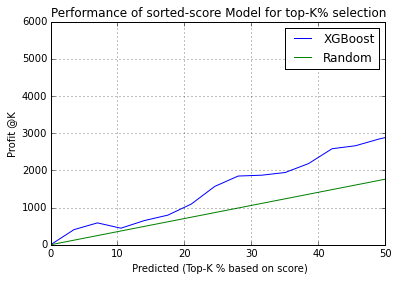

In [206]:
# helper function to return actual profit based on top K predictions   
def returnY(y_test, y_pred, N):
    profitK = []
    top20 = None # placeholder (not being used)
    for n in N: # N stores K, Y stores profit@top-K
        profit = np.sum(y_test[y_pred.argsort()[::-1][0:n]]) - (n-1)*0.68 # subtract cost
        profitK.append(profit)
    return profitK, top20   


topK = 50 # plot profit@topK for K in 0 to 20%
plt.xlim([0,topK]); plt.ylim([0,6000])
plt.rc('lines', linewidth=1)
linestyles = [ '-', '--', ':', '_']
colors = ['r', 'g', 'b']
styles = ['-r', '-g', '-b', '-m', '-c', '--b', '--c','-y', '-k', ':k']
#plt.plot([0,len(y_test)], [100*(sum(y_test)/len(y_test)),100*(sum(y_test)/len(y_test))], '--k', label = "Random")
plt.xlabel(" Predicted (Top-K % based on score)"); plt.ylabel("Profit @K ")
plt.title("Performance of sorted-score Model for top-K% selection")
N = range(1,len(a_test), 1000)
profitK, top20 =  returnY(a_test, probs_egb[:, 1], N);
plt.plot(100*np.array(N)/len(a_test), profitK, label = "XGBoost")
plt.plot(100*np.array(N)/len(a_test),(np.array(N)*sum(a_test)/len(a_test) - 0.68*(np.array(N)-1)), label = "Random")
plt.grid(True); plt.legend(loc = "upper right"); plt.show()

## Step 7. Modeling : Model 2 (Amount Prediction)

In [251]:
# Model 2: Predict Amounts
# Training Data (for training and tuning via R-squared): All donors with non-zero amounts
X_train_reg = X_train[a_train > 0]
a_train_reg = np.log(a_train[a_train > 0]) # perform log-transformation as described before 
# Testing Data for regression-evaluation using the r2 metric
X_test_reg = X_test[a_test > 0] 
a_test_reg = np.log(a_test[a_test > 0])
# Testing Data for full-evaluation using the business metric
X_test_full = X_test 
a_test_full = np.log(a_test)

In [30]:
np.exp(np.log(10)) # apply exponential to re-convert to real amount

10.000000000000002

In [266]:
# DEFINE MODELS (TRAINING AND TUNING)
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor 

# define lasso regresssion
def lassoRegression(X_train, y_train, X_test, state):
    print("training lasso... \n")
    # fit model
    alphas = np.linspace(1e-3, 10, 20)#
    lr = Lasso(fit_intercept=True, normalize=False, precompute=False, copy_X=True, max_iter=30000, tol=0.001, warm_start=False, positive=False, random_state=state, selection='cyclic')
    lr_cv = grid_search.GridSearchCV(estimator = lr, param_grid = dict(alpha= alphas), scoring = 'r2', 
                                     cv = 3)
    lr_cv = lr_cv.fit(X_train, y_train)
    # select the best estimator
    print(lr_cv.best_estimator_.alpha)
    lr_cv = lr_cv.best_estimator_.fit(X_train, y_train)
    # check number of coefficients selected
    print(np.count_nonzero(lr_cv.coef_))  #  non-zero coefficients 
    # check features and their coeffs.
    #print([ (x,y) for (x,y) in zip(X_train.columns[np.nonzero(lr_cv.coef_)[1]], lr_cv.coef_[0][np.nonzero(lr_cv.coef_[0])[0]])])
    # predict values for the test set
    predicted = lr_cv.predict(X_test)
    return predicted, lr_cv
# define ridge regresssion
def ridgeRegression(X_train, y_train, X_test, state):
    print("training ridge... \n")
    # fit model
    alphas = np.linspace(1e-3, 40, 20)#
    lr = Ridge(fit_intercept=True, normalize=False, copy_X=True, max_iter=30000, tol=0.0001, random_state=state)
    lr_cv = grid_search.GridSearchCV(estimator = lr, param_grid = dict(alpha= alphas), scoring = 'r2', 
                                     cv = 3)
    lr_cv = lr_cv.fit(X_train, y_train)
    # select the best estimator
    print(lr_cv.best_estimator_.alpha)
    lr_cv = lr_cv.best_estimator_.fit(X_train, y_train)
    # check number of coefficients selected
    print(np.count_nonzero(lr_cv.coef_))  #  non-zero coefficients 
    # check features and their coeffs.
    #print([ (x,y) for (x,y) in zip(X_train.columns[np.nonzero(lr_cv.coef_)[1]], lr_cv.coef_[0][np.nonzero(lr_cv.coef_[0])[0]])])
    # predict values for the test set
    predicted = lr_cv.predict(X_test)
    return predicted, lr_cv
# define elasticNet regresssion
def elasticRegression(X_train, y_train, X_test, state):
    print("training elasticNet... \n")
    # fit model
    alphas = np.linspace(1e-5, 10, 10)#
    l1_ratios = np.linspace(1e-5, 1, 10)#
    lr = ElasticNet(fit_intercept=True, normalize=False, precompute=False, copy_X=True, max_iter=20000, tol=0.0001, warm_start=False, positive=False, random_state=state, selection='cyclic')
    lr_cv = grid_search.GridSearchCV(estimator = lr, param_grid = dict(alpha= alphas, l1_ratio = l1_ratios), scoring = 'r2', 
                                     cv = 3)
    lr_cv = lr_cv.fit(X_train, y_train)
    # select the best estimator
    lr_cv = lr_cv.best_estimator_.fit(X_train, y_train)
    # check number of coefficients selected
    print(np.count_nonzero(lr_cv.coef_))  #  non-zero coefficients 
    # check features and their coeffs.
    #print([ (x,y) for (x,y) in zip(X_train.columns[np.nonzero(lr_cv.coef_)[1]], lr_cv.coef_[0][np.nonzero(lr_cv.coef_[0])[0]])])
    # predict values for the test set
    predicted = lr_cv.predict(X_test)
    return predicted, lr_cv
# bayesian optimization for hyperparameter-tuning of random forest
def randomForestReg(X_train, y_train, X_test, state):
    print("training randomForest... \n");    
    # set state
    np.random.seed(state)
    # define a search space
    space = {'max_depth': (1,10),
             'max_features': (0.1, 0.999),
             'min_samples_split': (1,20),
             'min_samples_leaf': (1,20),
             'n_estimators': (10, 100)
    }
    # minimize the objective over the space
    best = BayesianOptimization (lambda max_depth, min_samples_split, max_features, min_samples_leaf, n_estimators : 
                                 np.nanmean(cross_val_score(
            RandomForestRegressor(n_estimators = int(n_estimators), random_state = state,
                                   max_depth = int(max_depth),
                                   max_features = min(max_features, 0.999), 
                                   min_samples_split = int(min_samples_split), 
                                   min_samples_leaf = int(min_samples_leaf)),
                                 X_train, y_train, scoring='r2', 
                cv=3)), space) # X_, y_, scoring=make_scorer(precisionAtK), cv=5).mean(), space) #
    best.maximize()
    print(best.res['max']['max_params'])
    # obtain best fit
    best_fit = RandomForestRegressor(n_estimators = int(best.res['max']['max_params']['n_estimators']), random_state = state,
                                   max_depth = int(best.res['max']['max_params']['max_depth']),
                                   max_features = best.res['max']['max_params']['max_features'], 
                                   min_samples_split = int(best.res['max']['max_params']['min_samples_split']), 
                                   min_samples_leaf = int(best.res['max']['max_params']['min_samples_leaf']))
    rf_cv  = best_fit.fit(X_train, y_train)
    # predict values for the test set
    predicted = rf_cv.predict(X_test)
    # print importances
    importances = rf_cv.feature_importances_
    indices = np.argsort(importances)[::-1]
    # Print the feature ranking
    #print("Feature ranking:")
    #for f in range(X.shape[1]):
    #    print( (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
    return predicted, rf_cv 

In [267]:
# Compare models
#LASSO (L1)
predicted, lasso_cv = lassoRegression(X_train_reg, a_train_reg, X_test_reg, state); 
print("rsq:" + str(metrics.r2_score(a_test_reg, predicted)))
#RIDGE
predicted, ridge_cv = ridgeRegression(X_train_reg, a_train_reg, X_test_reg, state); 
print("rsq:" + str(metrics.r2_score(a_test_reg, predicted)))
#RandomForestRegressor
predicted, ridge_cv = randomForestReg(X_train_reg, a_train_reg, X_test_reg, state); 
print("rsq:" + str(metrics.r2_score(a_test_reg, predicted)))

training lasso... 

0.001
102
rsq:0.561576556308
training ridge... 

31.5791578947
425
rsq:0.547713390059
training randomForest... 

Initialization
------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   min_samples_leaf |   min_samples_split |   n_estimators | 
    1 | 00m03s |    0.61943 |      6.8130 |         0.1783 |            16.0428 |             13.1585 |        98.0757 | 
    2 | 00m01s |    0.58953 |      4.9383 |         0.1182 |            11.0490 |              3.7237 |        81.9243 | 
    3 | 00m11s |    0.62101 |      9.0260 |         0.8485 |            11.7928 |             18.9487 |        51.5331 | 
    4 | 00m15s |    0.62372 |      9.6730 |         0.7996 |            18.5863 |             10.9151 |        80.2476 | 
    5 | 00m02s |    0.61756 |      4.4510 |         0.8821 |             2.3497 |              8.8786 |        20.6447 | 

Random-Forest regression tree heavily outperforms L1/L2 linear regression models. We will use this as the model of choice for the amount prediction problem.
So,  full model looks like this:

Full Model = XGBoostClassifer [Predict Donor or Not] + RandomForestRegressor[Predict Amount]

In [33]:
# Final Regression Model
params = {'max_depth': 8.9662611093670375, 'max_features': 0.79590550154364426, 'n_estimators': 85.655939841871984, 'min_samples_split': 13.380911554984039, 'min_samples_leaf': 18.857538295558577}
rf =  RandomForestRegressor(n_estimators = int(params['n_estimators']), random_state = state,
                           max_depth = int(params['max_depth']),
                           max_features = min(params['max_features'], 0.999), 
                           min_samples_split = int(params['min_samples_split']), 
                           min_samples_leaf = int(params['min_samples_leaf']))

Given a candidate, Expected Revenue = (probability of donation)*predicted_amount .

Now, we can estimate both quantities -  probability AND amount.
Initially, we can test the scoring just based on amount. Here, we assume that all donors are equally likely to be donors i.e. a probability of 0.5.

In [34]:
# Estimating $ performance of regression predictions
# Get the $ amounts for the train-test data from before (use random_state to reproduce the split)
X_train, X_test, a_train, a_test = train_test_split(X, A, test_size=0.3, random_state=state)

# Training Data (for training and tuning via R-squared): All donors with non-zero amounts
X_train_reg = X_train[a_train > 0]
a_train_reg = np.log(a_train[a_train > 0]) # perform log-transformation as described before 
# Testing Data for full-evaluation using the business metric
X_test_full = X_test 
a_test_full = np.log(a_test)

rf = rf.fit(X_train_reg, a_train_reg)
a_pred = rf.predict(X_test_full)

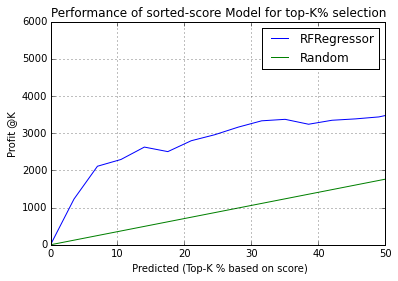

In [205]:
# define scoring metric for performance evaluation (compute profit given actual-log $ dono. amount and predicted-log of $ dollar amount )
#def profit(y_true, y_predicted):
#    profit_per = np.exp(y_true[np.exp(y_predicted) > 0.68])
#    score = np.sum(profit_per) - 0.68*len(profit_per)
#    return score

#    # only mail to the ones with predicted value > 0.68
#    expected_revenue = 0.5*np.exp(y_pred)
#    y_pred = y_pred[expected_revenue > 0.68]    
# helper function to return actual profit based on top K predictions   
def returnA(y_test, y_pred, N):
    profitK = []
    mailed = [] # placeholder (not being used)
    for n in N: # N stores K, Y stores profit@top-K
        profit = np.sum(np.exp(y_test[y_pred.argsort()[::-1][0:n]])) - (n-1)*0.68 # subtract cost
        profitK.append(profit)
    return profitK, mailed   


topK = 50# plot profit@topK for K in 0 to 20%
plt.xlim([0,topK]); plt.ylim([0,6000])
plt.rc('lines', linewidth=1)
linestyles = [ '-', '--', ':', '_']
colors = ['r', 'g', 'b']
styles = ['-r', '-g', '-b', '-m', '-c', '--b', '--c','-y', '-k', ':k']
#plt.plot([0,len(y_test)], [100*(sum(y_test)/len(y_test)),100*(sum(y_test)/len(y_test))], '--k', label = "Random")
plt.xlabel(" Predicted (Top-K % based on score)"); plt.ylabel("Profit @K ")
plt.title("Performance of sorted-score Model for top-K% selection")
N = range(1,len(a_test), 1000)
profitK, mailed =  returnA(a_test_full, a_pred, N);
plt.plot(100*np.array(N)/len(a_test), profitK, label = "RFRegressor")
plt.plot(100*np.array(N)/len(a_test),(np.array(N)*sum(a_test)/len(a_test) - 0.68*(np.array(N)-1)), label = "Random")
plt.grid(True); plt.legend(loc = "upper right"); plt.show()

In [37]:
sum(a_test) - 0.68*len(a_test)

3526.1899999999951

## Step 8. Full model fit and evaluation

In [38]:
# Now, let's look at the full-model performance
state = 0
X_train, X_test, a_train, a_test = train_test_split(X, A, test_size=0.3, random_state=state)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=state)
# scaling
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

# Classification Training Data
# X_train, y_train
# Regression Training Data (for training and tuning via R-squared): All donors with non-zero amounts
X_train_reg = X_train[a_train > 0]
a_train_reg = np.log(a_train[a_train > 0]) # perform log-transformation as described before

# Testing Data for full-evaluation using the business metric
X_test_full = X_test 
a_test_full = np.log(a_test)


np.random.seed(state)
params = {'max_depth': 2.856221488164838, 'colsample_bytree': 0.44262663808901137, 'subsample': 0.69794826522466824, 'n_estimators': 137.41598006134393, 'learning_rate': 0.060587342759723481, 'min_child_weight': 17.160542012723546, 'gamma': 0.47842271033837591, 'max_delta_step': 4.9676729987848152}
# balance classes weights
weight = sum(y_train == 0)/ sum(y_train == 1) #https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
egb =     XGBClassifier(max_depth = int(params['max_depth']),
                 learning_rate = params['learning_rate'],
                 n_estimators = int(params['n_estimators']),
                 silent = True,
                 nthread = -1,
                 gamma = params['gamma'],
                 min_child_weight = int(params['min_child_weight']),
                 max_delta_step = params['max_delta_step'],
                 subsample = params['subsample'],
                 colsample_bytree = params['colsample_bytree'],
                 seed = state,
                 scale_pos_weight = weight,
                 objective = "binary:logistic")
egb = egb.fit(X_train, y_train) # final classification model object
probs_egb = egb.predict_proba(X_test_full)

# Final Regression Model
params = {'max_depth': 8.9662611093670375, 'max_features': 0.79590550154364426, 'n_estimators': 85.655939841871984, 'min_samples_split': 13.380911554984039, 'min_samples_leaf': 18.857538295558577}
rf =  RandomForestRegressor(n_estimators = int(params['n_estimators']), random_state = state,
                           max_depth = int(params['max_depth']),
                           max_features = min(params['max_features'], 0.999), 
                           min_samples_split = int(params['min_samples_split']), 
                           min_samples_leaf = int(params['min_samples_leaf']))
rf = rf.fit(X_train_reg, a_train_reg)
a_pred = rf.predict(X_test_full) # final regression model object   
y_pred_full = probs_egb[:,1]*np.exp(a_pred)                                 

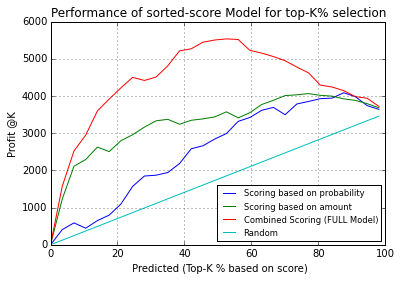

In [202]:
# Evaluation of the full-metric
def returnA(y_test, y_pred, N):
    profitK = []
    thresh = [] # placeholder (not being used)
    for n in N: # N stores K, Y stores profit@top-K
        profit = np.sum(np.exp(y_test[y_pred.argsort()[::-1][0:n]])) - (n-1)*0.68 # subtract cost
        profitK.append(profit)
        thresh.append(min(y_pred[y_pred.argsort()[::-1][0:n]]))
    return profitK, thresh   


topK = 100 # plot profit@topK for K in 0 to 20%
plt.xlim([0,topK]); plt.ylim([0,6000])
plt.rc('lines', linewidth=1)
linestyles = [ '-', '--', ':', '_']
colors = ['r', 'g', 'b']
styles = ['-r', '-g', '-b', '-m', '-c', '--b', '--c','-y', '-k', ':k']
#plt.plot([0,len(y_test)], [100*(sum(y_test)/len(y_test)),100*(sum(y_test)/len(y_test))], '--k', label = "Random")
plt.xlabel(" Predicted (Top-K % based on score)"); plt.ylabel("Profit @K ")
plt.title("Performance of sorted-score Model for top-K% selection")
N = range(1,len(a_test), 1000)
profitK, thresh =  returnA(a_test_full, probs_egb[:,1], N);
plt.plot(100*np.array(N)/len(a_test), profitK, label = "Scoring based on probability")
profitK, thresh =  returnA(a_test_full, (a_pred), N);
plt.plot(100*np.array(N)/len(a_test), profitK, label = "Scoring based on amount ")
profitK, thresh =  returnA(a_test_full, probs_egb[:,1]*a_pred, N);
plt.plot(100*np.array(N)/len(a_test), profitK, label = "Combined Scoring (FULL Model)")
plt.plot(100*np.array(N)/len(a_test),(np.array(N)*sum(a_test)/len(a_test) - 0.68*(np.array(N)-1)), label = "Random")
plt.grid(True); plt.legend(loc = "lower right", fontsize = "small"); plt.show()

It appears if we choose a scoring threshold corresponding to picking top-50% (score > 1.2), we will maximize the profit.

In [46]:
print(max(profitK))
print(np.where(profitK == np.max(profitK)))
profitK[14:18], N[14:18], thresh[14:18]

5535.29
(array([15]),)


([5505.2899999999991,
  5535.2899999999991,
  5519.2900000000009,
  5226.2900000000009],
 range(14001, 18001, 1000),
 [1.2328017274430183,
  1.2148405656531893,
  1.1967276232056783,
  1.1787084933141669])

## Step 9. Load and score validation set

In [248]:
# follow the same data-preparation steps as before to build the training data
data = pd.read_csv("cup98LRN.txt", sep = ",", error_bad_lines = False, dtype = featureType, warn_bad_lines  = False) 
valData  = pd.read_csv("cup98VAL.txt", sep = ",", error_bad_lines = False, dtype = featureType, warn_bad_lines  = False)

# populate missing data
imputedValues = imputeMissingData(data) # use same values as used for model
valData.fillna(imputedValues, inplace = True);

In [231]:
# keep a record of skipped lines while file 'cup98VAL.txt' was read
allLines = []
f = open("cup98VAL.txt", "r") 
for line in f:
    allLines.append(line.split(",")[469])
f.close()
allLines.remove('CONTROLN')
allLines = [int(x) for x in allLines]
skipped = set(allLines) - set(valData['CONTROLN']) # for now, ignore these skipped lines (predict a zero score for these)
len(allLines)

96367

In [249]:
# clean and truncate zip codes
import re
valData['ZIP'] = valData['ZIP'].apply(lambda x: re.sub("-", "", x)).apply(lambda x: x[0:2])

# TRANSFORM Categorical features into 0/1 Indicator variables
valIndicatorDf = pd.DataFrame(index = valData.index)
for c in valData.columns:
    if featureType[c] == 'O' and c != 'OSOURCE':
        valIndicatorDf = pd.concat([valIndicatorDf, pd.get_dummies(valData[c], prefix = c)], axis = 1)
        
# TRANSFORM the population variable  
logT = lambda x: np.log(1 + x if x is not None and not np.isnan(x) else 1)
valData['POP901'] = valData['POP901'].apply(lambda x: logT(x))
valData['POP902'] = valData['POP902'].apply(lambda x: logT(x))
valData['POP903'] = valData['POP903'].apply(lambda x: logT(x))

In [209]:
# ASSEMBLE THE Full matrix
valTemp = pd.concat([valData, valIndicatorDf], axis = 1)
# drop the original categorical attributes (now mapped to 0/1 features)
for feature in valData.columns: 
    if featureType[feature] == 'O':
        valTemp.drop(feature, axis = 1, inplace = True)

In [180]:
# select the columns that were used for model-building
selColumns = pd.read_csv("X.csv")
selColumns = selColumns.columns
val = valTemp[selColumns]

In [181]:
# apply scaling transformation
X_val  = min_max_scaler.transform(val)

In [182]:
X_val.shape
# make predictions
p_score = egb.predict_proba(X_val)
a_score = rf.predict(X_val)
tot_score = p_score[:,1]*a_score

In [283]:
# write output to file
output = valData['CONTROLN']
score = pd.DataFrame(columns = (['score']))
score['score'] = tot_score
output = pd.concat([output, score], axis = 1)

In [284]:
output.head()

,CONTROLN,score
0,188946,1.097982
1,126296,1.199477
2,155244,1.244890
3,123985,1.112903
4,119118,1.177234


In [285]:
output['TARGET_B'] = output['score'].apply(lambda x: 1 if x > 1.2 else 0)
output['TARGET_D'] = output['score'].apply(lambda x: x if x > 1.2 else 0)
output.drop('score', axis = 1, inplace = True)

In [286]:
output['CONTROLN'] = output['CONTROLN'].apply(lambda x: x.astype('int'))
output.to_csv('predictions.txt', index = False)

# Future Work:
* Spatial Clustering on Zip codes based on eucledian distance between codes (maybe useful but given high-dimensionality haven't done yet)
* Spectral clustering on features to introduce non-linear interactions between features ( high performance of tree-based models indicates presence of non-linear interactions)
* Calibrating the predicted values using a sigmoid or other monotonically increasing function so that predicted value TARGET_D translates to real revenue.

###Tech Stack:
Add PySpark for speed.